# Gradient boosting vs accelerated gradient boosting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Classe AcceleratedGradientBoosting (AGB) qui implémente un algorithme de Gradient Boosting accéléré
class AcceleratedGradientBoosting:
    def __init__(self, loss='ls', learning_rate=0.1, n_estimators=2500, max_depth=2):
        # Initialisation des hyperparamètres de l'algorithme
        self.loss = loss  # Type de fonction de perte ('ls' pour Least Squares, ou perte quadratique)
        self.learning_rate = learning_rate  # Taux d'apprentissage
        self.n_estimators = n_estimators  # Nombre d'itérations ou d'estimateurs
        self.max_depth = max_depth  # Profondeur maximale des arbres de décision
        self.models = []  # Liste pour stocker les modèles d'arbres à chaque itération
        self.w = []  # Liste pour stocker les poids associés à chaque arbre
        self.lambda_t = [0]  # Initialisation de lambda pour la mise à jour accélérée
        self.gamma_t = [1]  # Initialisation de gamma pour la mise à jour accélérée

    def _loss_gradient(self, y_true, y_pred):
        # Calcul du gradient de la fonction de perte
        if self.loss == 'ls':
            return y_pred - y_true  # Gradient pour la perte quadratique (Least Squares)
        elif self.loss == 'adaboost':
            return -y_true * np.exp(-y_true * y_pred)  # Gradient pour la perte d'Adaboost
        else:
            raise ValueError("Fonction de perte non reconnue.")  # Lever une erreur si la fonction de perte est invalide

    def fit(self, X, y):
        # Initialisation des prédictions et du gradient pour l'algorithme
        F_t = np.zeros_like(y)  # Prédictions initiales (commence par 0)
        G_t = np.copy(F_t)  # Initialisation du gradient

        # Boucle d'entraînement pour chaque itération (n_estimators étapes)
        for t in range(self.n_estimators):
            # Calcul du résidu (gradient négatif) entre la prédiction actuelle et la vraie valeur
            Z_t = -self._loss_gradient(y, G_t)

            # Construction d'un nouvel arbre de régression avec une profondeur limitée
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, Z_t)  # Entraîner l'arbre sur le gradient résiduel
            self.models.append(model)  # Ajouter le modèle à la liste des arbres

            # Appliquer l'arbre pour partitionner les données en régions
            R_j = model.apply(X)
            unique_regions = np.unique(R_j)  # Identifier les régions uniques
            w_j = np.zeros_like(unique_regions, dtype=float)  # Initialiser les poids des régions

            # Calculer les poids pour chaque région (moyenne du gradient dans chaque région)
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                w_j[j] = np.mean(Z_t[mask])  # Poids basé sur le gradient moyen dans la région
            self.w.append(w_j)  # Stocker les poids

            # Mise à jour des prédictions en utilisant les nouvelles régions et les nouveaux poids
            F_t_plus_1 = np.copy(F_t)
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                F_t_plus_1[mask] += self.learning_rate * w_j[j]  # Mise à jour avec le taux d'apprentissage

            # Mise à jour des paramètres de Nesterov (lambda et gamma) pour accélérer l'algorithme
            lambda_t = (1 + np.sqrt(1 + 4 * self.lambda_t[-1]**2)) / 2
            gamma_t = (1 - self.lambda_t[-1]) / lambda_t
            self.lambda_t.append(lambda_t)
            self.gamma_t.append(gamma_t)

            # Mise à jour du gradient en combinant l'ancien et le nouveau modèle selon gamma
            G_t = (1 - gamma_t) * F_t_plus_1 + gamma_t * F_t
            F_t = np.copy(F_t_plus_1)  # Mettre à jour les prédictions actuelles

    def predict(self, X):
        # Initialiser les prédictions moyennes en utilisant les modèles ajustés
        F_t = np.zeros(X.shape[0]) + np.mean([model.predict(X) for model in self.models], axis=0)

        # Ajuster les prédictions finales en parcourant chaque arbre
        for t, model in enumerate(self.models):
            R_j = model.apply(X)  # Appliquer le modèle pour obtenir les régions
            unique_regions = np.unique(R_j)  # Obtenir les régions uniques
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                F_t[mask] += self.learning_rate * self.w[t][j]  # Ajouter les prédictions pondérées
        return F_t  # Retourner les prédictions finales

# Fonction pour entraîner et évaluer les modèles
def evaluate_model(n, d, func):
    # Générer des données aléatoires de dimension (n, d)
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = func(X)  # Générer les cibles à partir de la fonction fournie

    # Séparer les données en ensemble d'entraînement, de validation et de test
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.5, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    # Initialiser les meilleures erreurs quadratiques moyennes (MSE)
    best_mse_agb = float('inf')
    best_mse_gbr = float('inf')

    # Listes pour stocker les MSE (pour analyse des performances)
    mse_agb_list = []
    mse_gbr_list = []

    # Tester plusieurs taux d'apprentissage
    for learning_rate in [1e-5, 0.001, 0.01, 0.1, 0.5]:
        # Entraîner le modèle AGB avec différents taux d'apprentissage
        agb = AcceleratedGradientBoosting(loss='ls', learning_rate=learning_rate, n_estimators=2500, max_depth=2)
        agb.fit(X_train, Y_train)  # Ajuster sur l'ensemble d'entraînement
        Y_pred_agb = agb.predict(X_val)  # Prédire sur l'ensemble de validation
        mse_agb = mean_squared_error(Y_val, Y_pred_agb)  # Calculer la MSE
        mse_agb_list.append(mse_agb)  # Stocker la MSE

        # Mettre à jour la meilleure MSE pour AGB
        if mse_agb < best_mse_agb:
            best_mse_agb = mse_agb

        # Entraîner le modèle classique de Gradient Boosting (GBR)
        gbr = GradientBoostingRegressor(loss='squared_error', learning_rate=learning_rate, n_estimators=2500, max_depth=2)
        gbr.fit(X_train, Y_train)  # Ajuster sur l'ensemble d'entraînement
        Y_pred_gbr = gbr.predict(X_val)  # Prédire sur l'ensemble de validation
        mse_gbr = mean_squared_error(Y_val, Y_pred_gbr)  # Calculer la MSE
        mse_gbr_list.append(mse_gbr)  # Stocker la MSE

        # Mettre à jour la meilleure MSE pour GBR
        if mse_gbr < best_mse_gbr:
            best_mse_gbr = mse_gbr

    # Entraînement final avec un taux d'apprentissage fixe (0,01) et évaluation sur l'ensemble de test
    agb_final = AcceleratedGradientBoosting(loss='ls', learning_rate=0.01, n_estimators=2500, max_depth=2)
    agb_final.fit(X_train, Y_train)  # Ajuster sur l'ensemble d'entraînement
    Y_pred_agb_final = agb_final.predict(X_test)  # Prédire sur l'ensemble de test
    mse_agb_final = mean_squared_error(Y_test, Y_pred_agb_final)  # Calculer la MSE finale pour AGB

    gbr_final = GradientBoostingRegressor(loss='squared_error', learning_rate=0.01, n_estimators=2500, max_depth=2)
    gbr_final.fit(X_train, Y_train)  # Ajuster sur l'ensemble d'entraînement
    Y_pred_gbr_final = gbr_final.predict(X_test)  # Prédire sur l'ensemble de test
    mse_gbr_final = mean_squared_error(Y_test, Y_pred_gbr_final)  # Calculer la MSE finale pour GBR

    # Retourner les MSE finales des deux modèles ainsi que les MSE intermédiaires pour analyse
    return mse_agb_final, mse_gbr_final, mse_agb_list, mse_gbr_list


## Modèle 1. n = 1 000, d = 100

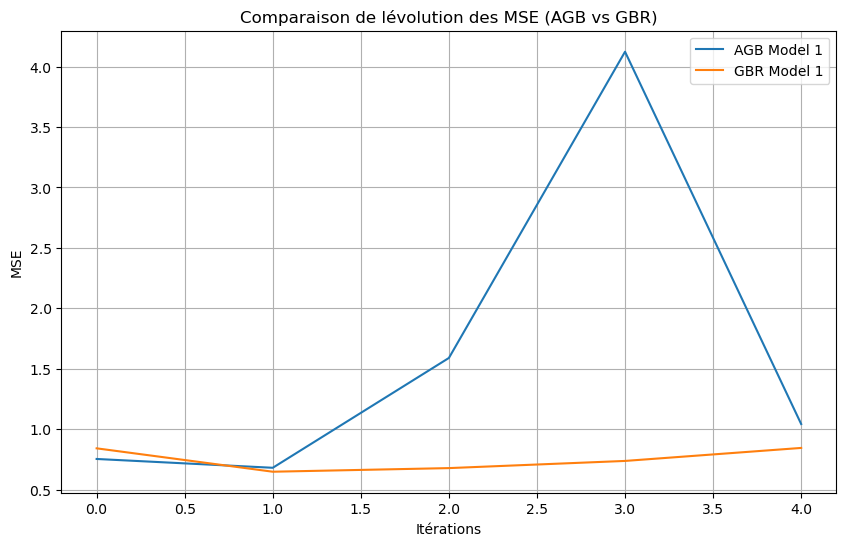

In [2]:
# Définition des fonctions de chaque modèle
def model_1(X):
    return X[:, 0] * X[:, 1] + X[:, 2]**3 - X[:, 3] * X[:, 6] + X[:, 7] * X[:, 9] - X[:, 5]**2 + np.random.normal(0, 0.5, X.shape[0])


# Évaluation des modèles
mse_results = []
mse_agb_lists = []
mse_gbr_lists = []

mse_1, mse_2, mse_agb_1, mse_gbr_1 = evaluate_model(1000, 100, model_1)  # Évaluer le modèle 1

# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(mse_agb_1, label='AGB Model 1')
plt.plot(mse_gbr_1, label='GBR Model 1')

plt.title('Comparaison de l''évolution des MSE (AGB vs GBR)')
plt.xlabel('Itérations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## Modèle 2. n = 800, d = 100

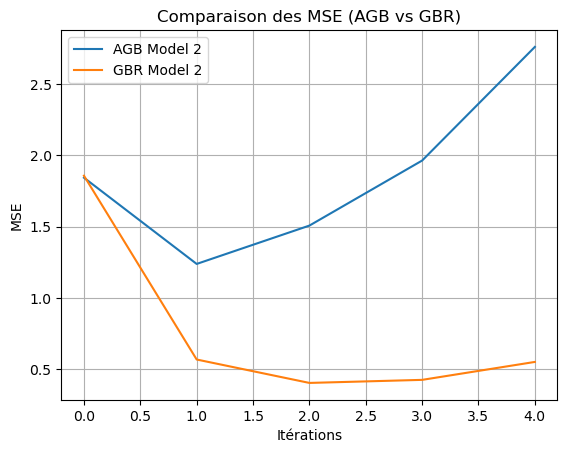

In [4]:
# Définition des fonctions de chaque modèle
def model_2(X):
    return -np.sin(2 * X[:, 0]) + X[:, 1]**2 + X[:, 2] - np.exp(-X[:, 3]) + np.random.normal(0, 0.5, X.shape[0])


# Évaluation des modèles
mse_results = []
mse_agb_lists = []
mse_gbr_lists = []

mse_3, mse_4, mse_agb_2, mse_gbr_2 = evaluate_model(800, 100, model_2)   # Évaluer le modèle 2

# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(mse_agb_2, label='AGB Model 2')
plt.plot(mse_gbr_2, label='GBR Model 2')

plt.title('Comparaison des MSE (AGB vs GBR)')
plt.xlabel('Itérations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


## Modèle 3. n = 1 000, d = 500

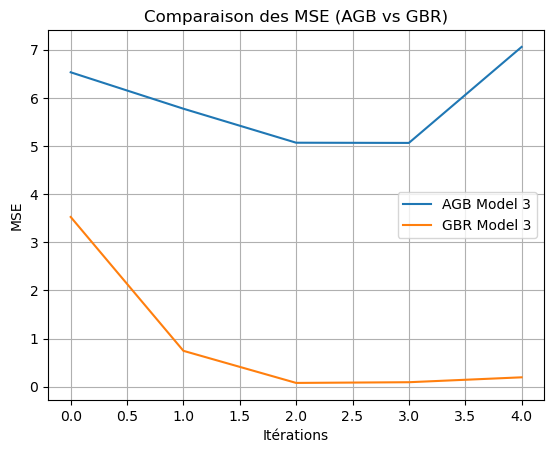

In [5]:
# Définition des fonctions de chaque modèle
def model_3(X):
    return X[:, 0] + 3 * X[:, 1]**3 - 2 * np.exp(-X[:, 4]) + X[:, 5]

# Évaluation des modèles
mse_results = []
mse_agb_lists = []
mse_gbr_lists = []


mse_5, mse_6, mse_agb_3, mse_gbr_3 = evaluate_model(1000, 500, model_3)  # Évaluer le modèle 3


# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(mse_agb_3, label='AGB Model 3')
plt.plot(mse_gbr_3, label='GBR Model 3')

plt.title('Comparaison des MSE (AGB vs GBR)')
plt.xlabel('Itérations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## Modèle 4. n = 2000, d = 30

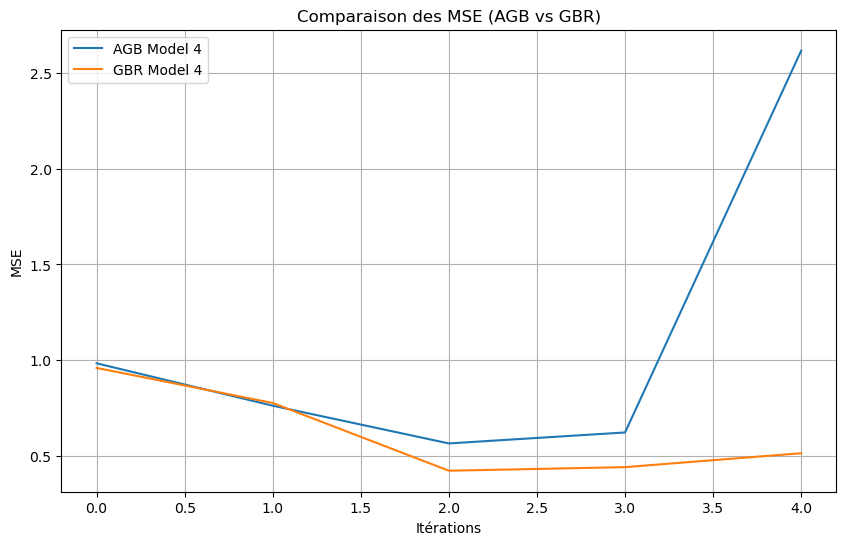

In [6]:
# Définition des fonctions de chaque modèle

def model_4(X):
    correlated = False
    indicator = (np.sum(X[:, :10] ** 2, axis=1) > (3.5 if not correlated else 9.34)).astype(int)
    return 2 * indicator - 1



# Évaluation des modèles
mse_results = []
mse_agb_lists = []
mse_gbr_lists = []


mse_7, mse_8, mse_agb_4, mse_gbr_4 = evaluate_model(2000, 30, model_4)   # Évaluer le modèle 4


# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(mse_agb_4, label='AGB Model 4')
plt.plot(mse_gbr_4, label='GBR Model 4')

plt.title('Comparaison des MSE (AGB vs GBR)')
plt.xlabel('Itérations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## Modèle 5. n = 1 000, d = 25

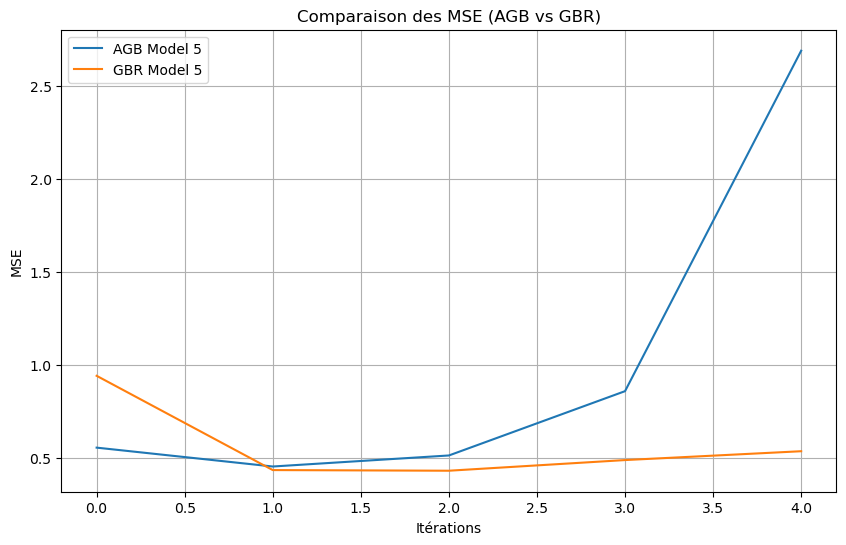

In [7]:
# Définition des fonctions de chaque modèle

def model_5(X):
    indicator = (X[:, 0] + X[:, 2] ** 4 + X[:, 8] + np.sin(X[:, 11] * X[:, 17]) > 0.38).astype(int)
    return 2 * indicator - 1 + np.random.normal(0, 0.1, X.shape[0])
# Évaluation des modèles
mse_results = []
mse_agb_lists = []
mse_gbr_lists = []


mse_9, mse_10, mse_agb_5, mse_gbr_5 = evaluate_model(1000, 25, model_5)  # Évaluer le modèle 5


# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(mse_agb_5, label='AGB Model 5')
plt.plot(mse_gbr_5, label='GBR Model 5')
plt.title('Comparaison des MSE (AGB vs GBR)')
plt.xlabel('Itérations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## Un exemple jouet <a id="part3"></a>

Pour une première compréhension du concept de Boosting, on utilisera un jeu de données $\mathcal{D}_n$ issues d'un modèle très simple basé sur la fonction $x \mapsto \sin(x)$. On se restreint, pour cela à un espace d'observation $\mathcal X = [0;5]$ et $\mathcal Y = \mathbb R$ de dimensions $1$. On considère le modèle de régression suivant :
$$Y = f(X) + \varepsilon,$$

où $X \sim \mathcal U_{[0;5]}, \varepsilon \sim \mathcal U_{[-0.5;0.5]}$ avec probabilité $p=\frac{1}{5}$, $\varepsilon = 0$ sinon et $f = \sin$.

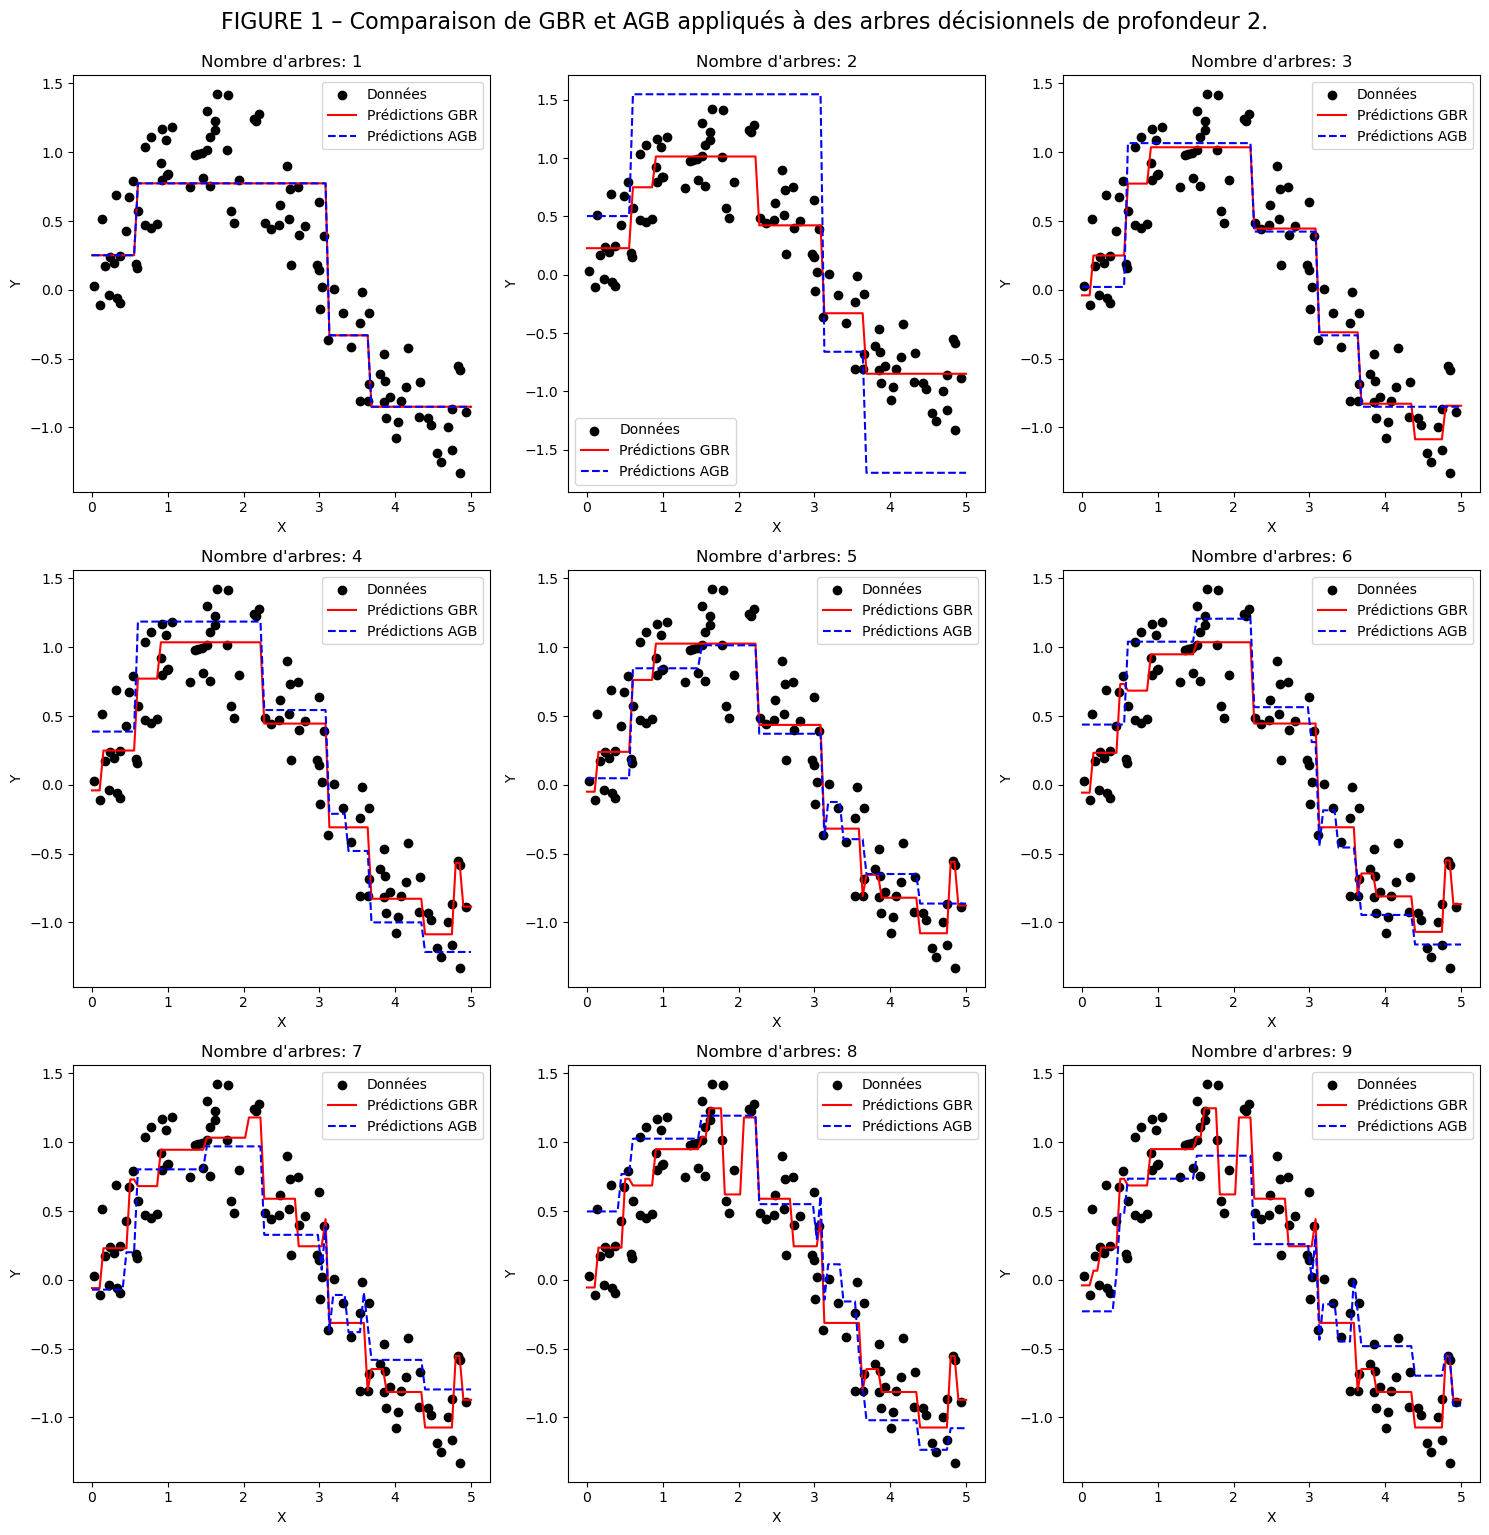

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1. Simulation des données
np.random.seed(42)
n_samples = 100
X = np.random.uniform(0, 5, size=(n_samples, 1))
epsilon = np.random.uniform(-0.5, 0.5, size=n_samples) * (np.random.rand(n_samples) < 4/5)
Y = np.sin(X.flatten()) + epsilon

# Classe AcceleratedGradientBoosting (AGB) qui implémente l'algorithme
class AcceleratedGradientBoosting:
    def __init__(self, loss='ls', learning_rate=0.1, n_estimators=2500, max_depth=2):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.w = []
        self.lambda_t = [0]
        self.gamma_t = [1]

    def _loss_gradient(self, y_true, y_pred):
        # Calcul du gradient de la perte
        if self.loss == 'ls':
            return y_pred - y_true  # Gradient pour la perte quadratique
        elif self.loss == 'adaboost':
            return -y_true * np.exp(-y_true * y_pred)  # Gradient pour la perte d'Adaboost
        else:
            raise ValueError("Fonction de perte non reconnue.")

    def fit(self, X, y):
        # Initialiser les prédictions
        F_t = np.zeros(len(y))  # Valeur initiale pour F_0
        G_t = np.copy(F_t)  # Variable G_t (extrapolée)

        for t in range(self.n_estimators):
            Z_t = -self._loss_gradient(y, G_t)
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, Z_t)
            self.models.append(model)

            # Diviser X en régions distinctes selon l'arbre de décision
            R_j = model.apply(X)
            unique_regions = np.unique(R_j)
            w_j = np.zeros_like(unique_regions, dtype=float)

            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                w_j[j] = np.mean(Z_t[mask])
            self.w.append(w_j)

            # Mise à jour des prédictions
            F_t_plus_1 = np.copy(F_t)
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                F_t_plus_1[mask] += self.learning_rate * w_j[j]

            # Mise à jour des valeurs de lambda et gamma
            lambda_t = (1 + np.sqrt(1 + 4 * self.lambda_t[-1]**2)) / 2
            gamma_t = (1 - self.lambda_t[-1]) / lambda_t
            self.lambda_t.append(lambda_t)
            self.gamma_t.append(gamma_t)

            G_t = (1 - gamma_t) * F_t_plus_1 + gamma_t * F_t
            F_t = np.copy(F_t_plus_1)

    def predict(self, X):
        F_t = np.zeros(X.shape[0])
        for t, model in enumerate(self.models):
            R_j = model.apply(X)
            unique_regions = np.unique(R_j)
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                F_t[mask] += self.learning_rate * self.w[t][j]
        return F_t

# Définir les paramètres du modèle de boosting
max_trees = 9
learning_rate = 1.0
max_depth = 2

# Créer un espace pour les prédictions
x_range = np.linspace(0, 5, 100).reshape(-1, 1)

# Initialisation de la figure pour les sous-figures
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Itérer pour différents nombres d'arbres
for n_trees in range(1, max_trees + 1):
    # Créer un modèle de GBR avec `n_trees` arbres
    gbr_model = GradientBoostingRegressor(n_estimators=n_trees, 
                                          max_depth=max_depth, 
                                          learning_rate=learning_rate, 
                                          loss='squared_error')
    gbr_model.fit(X, Y)
    Y_gbr_pred = gbr_model.predict(x_range)
    
    # Créer un modèle AGB avec `n_trees` arbres
    agb_model = AcceleratedGradientBoosting(n_estimators=n_trees, learning_rate=learning_rate, max_depth=max_depth)
    agb_model.fit(X, Y)
    Y_agb_pred = agb_model.predict(x_range)

    # Tracer les résultats pour GBR
    ax = axes[n_trees - 1]
    ax.scatter(X, Y, color='black', label='Données')
    ax.plot(x_range, Y_gbr_pred, color='red', label='Prédictions GBR')
    
    # Tracer les résultats pour AGB
    ax.plot(x_range, Y_agb_pred, color='blue', linestyle='--', label='Prédictions AGB')
    ax.set_title(f'Nombre d\'arbres: {n_trees}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

# Ajuster les espacements
plt.tight_layout()
fig.suptitle("FIGURE 1 – Comparaison de GBR et AGB appliqués à des arbres décisionnels de profondeur 2.", fontsize=16, y=1.02)
# Enregistrer la figure
plt.savefig("comparison_agb_gbr_decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()


## Gradient boosting vs accelerated gradient boosting en fonction de differents pas

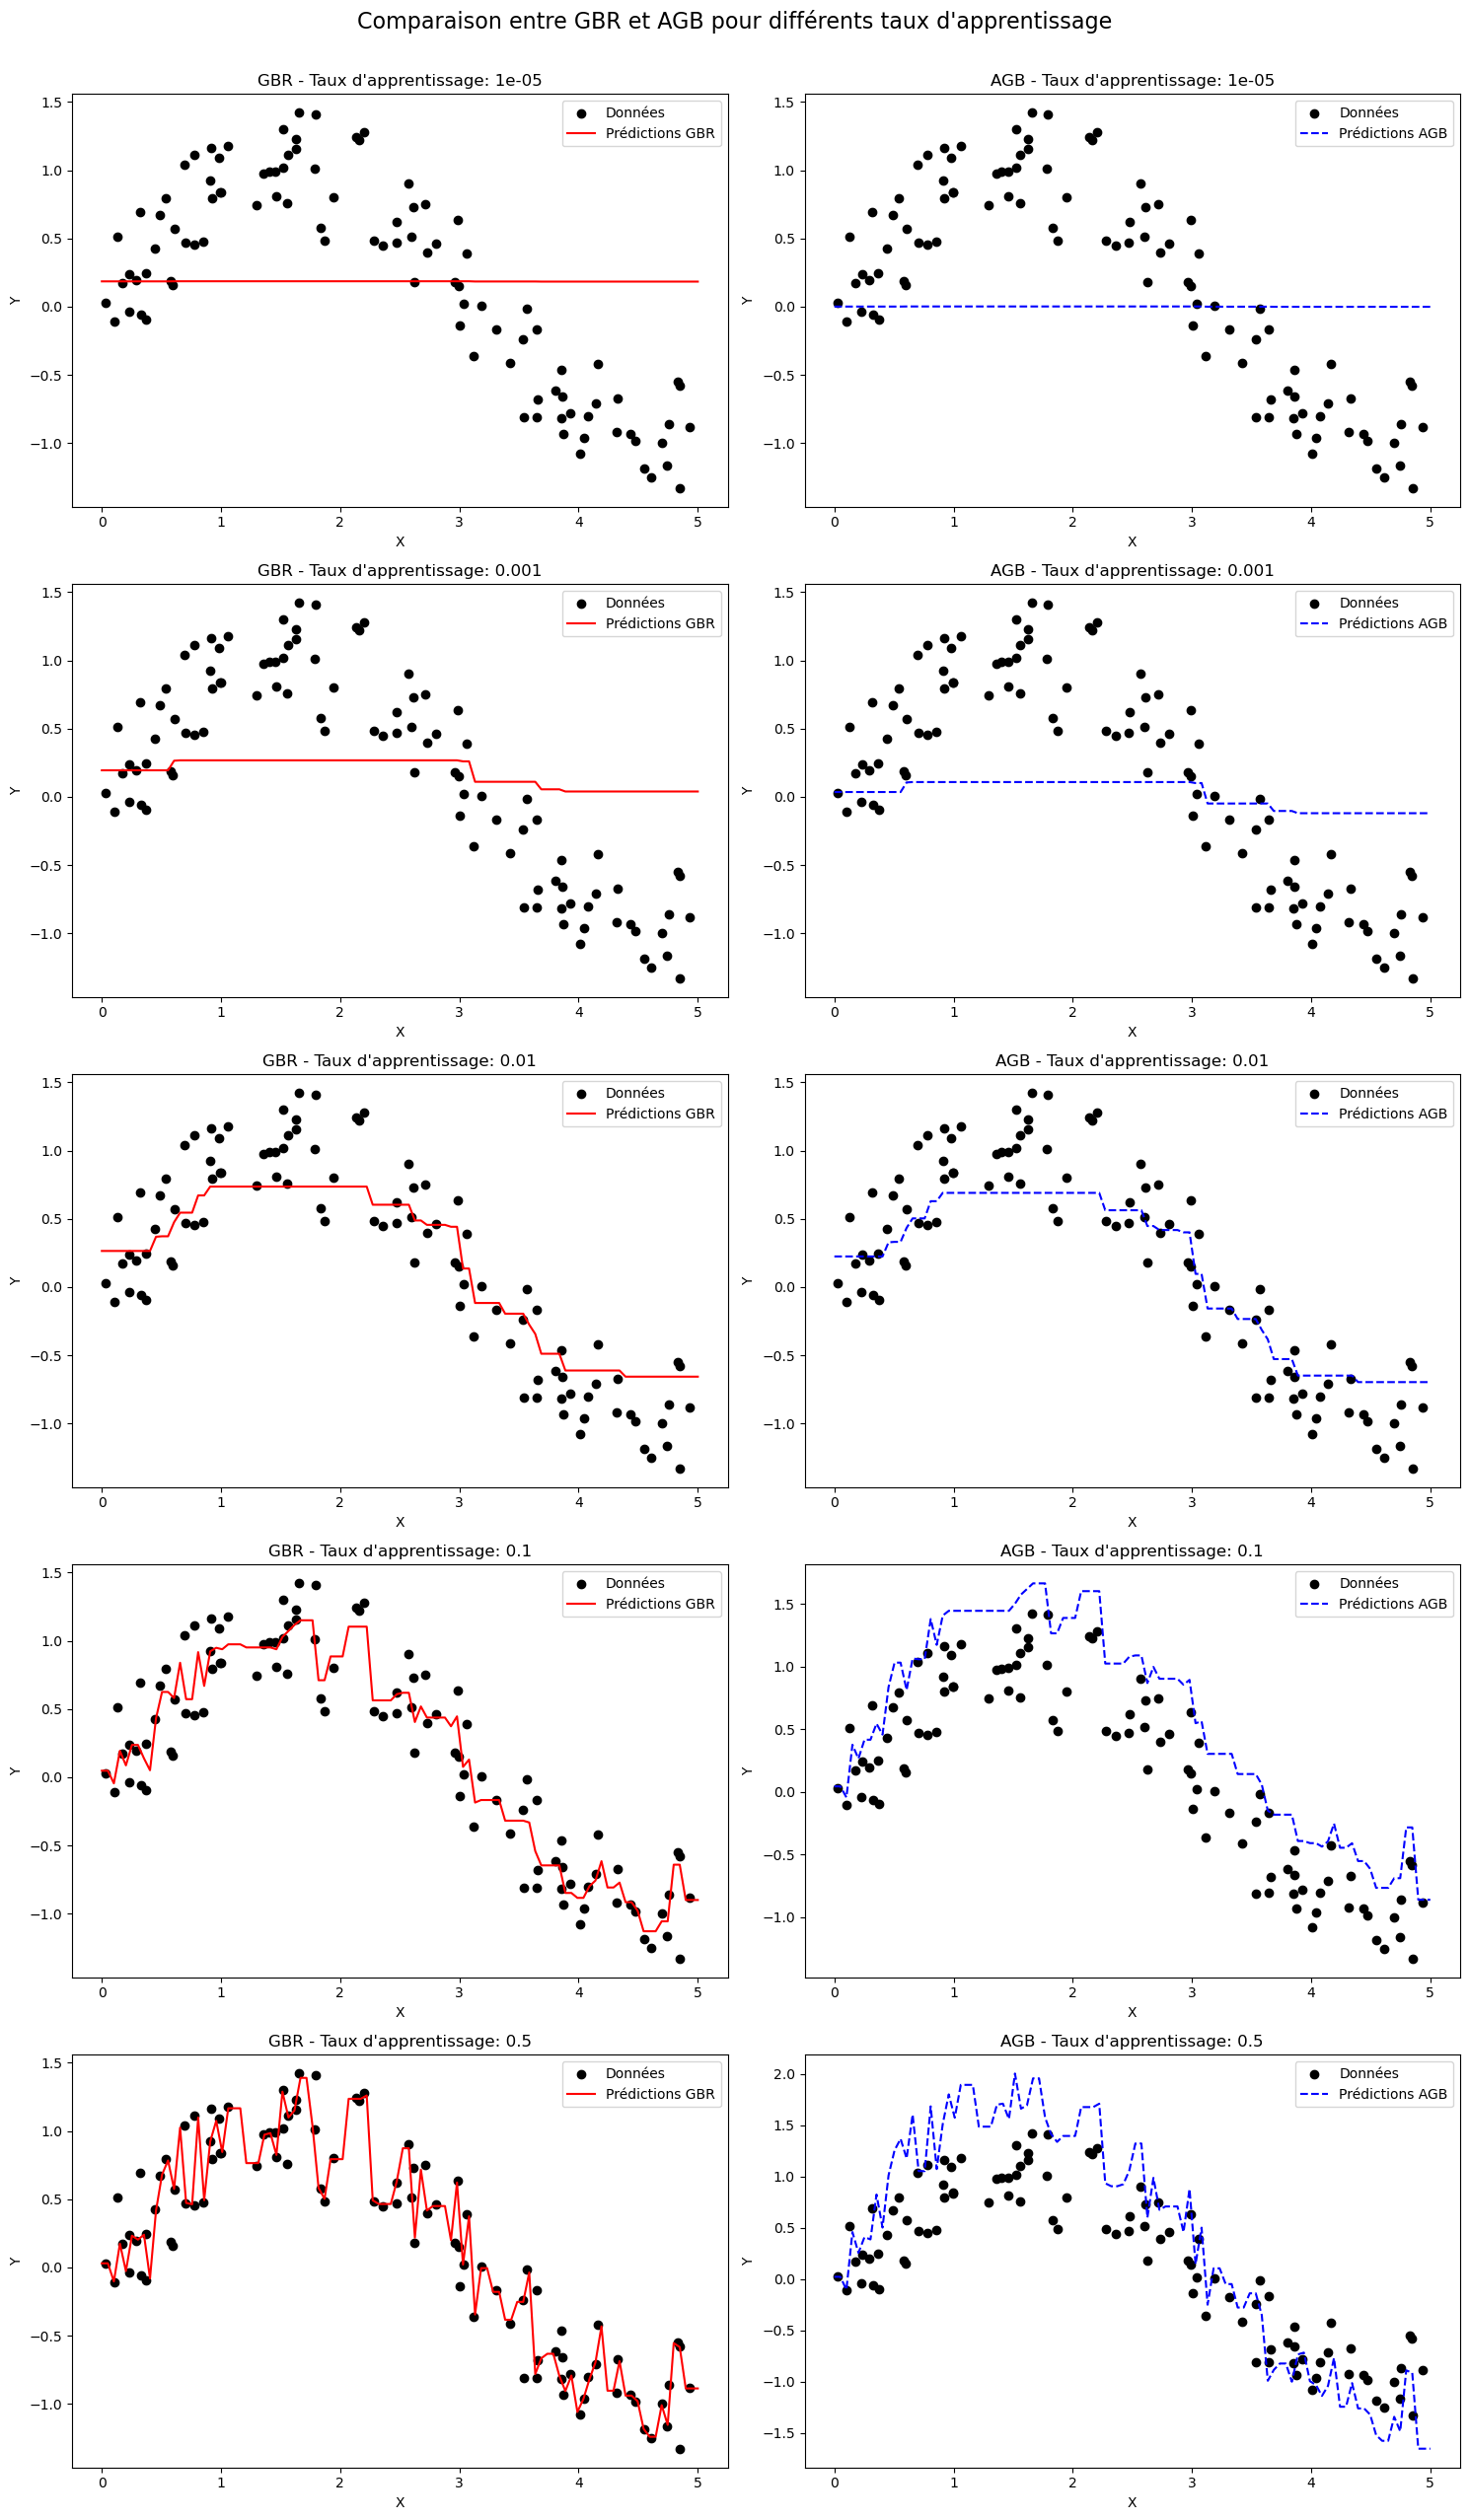

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1. Simulation des données
np.random.seed(42)
n_samples = 100
X = np.random.uniform(0, 5, size=(n_samples, 1))
epsilon = np.random.uniform(-0.5, 0.5, size=n_samples) * (np.random.rand(n_samples) < 4/5)
Y = np.sin(X.flatten()) + epsilon

# Classe AcceleratedGradientBoosting (AGB)
class AcceleratedGradientBoosting:
    def __init__(self, loss='ls', learning_rate=0.1, n_estimators=2500, max_depth=2):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.w = []
        self.lambda_t = [0]
        self.gamma_t = [1]

    def _loss_gradient(self, y_true, y_pred):
        if self.loss == 'ls':
            return y_pred - y_true
        elif self.loss == 'adaboost':
            return -y_true * np.exp(-y_true * y_pred)
        else:
            raise ValueError("Fonction de perte non reconnue.")

    def fit(self, X, y):
        F_t = np.zeros(len(y))
        G_t = np.copy(F_t)

        for t in range(self.n_estimators):
            Z_t = -self._loss_gradient(y, G_t)
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, Z_t)
            self.models.append(model)

            R_j = model.apply(X)
            unique_regions = np.unique(R_j)
            w_j = np.zeros_like(unique_regions, dtype=float)

            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                w_j[j] = np.mean(Z_t[mask])
            self.w.append(w_j)

            F_t_plus_1 = np.copy(F_t)
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                F_t_plus_1[mask] += self.learning_rate * w_j[j]

            lambda_t = (1 + np.sqrt(1 + 4 * self.lambda_t[-1]**2)) / 2
            gamma_t = (1 - self.lambda_t[-1]) / lambda_t
            self.lambda_t.append(lambda_t)
            self.gamma_t.append(gamma_t)

            G_t = (1 - gamma_t) * F_t_plus_1 + gamma_t * F_t
            F_t = np.copy(F_t_plus_1)

    def predict(self, X):
        F_t = np.zeros(X.shape[0])
        for t, model in enumerate(self.models):
            R_j = model.apply(X)
            unique_regions = np.unique(R_j)
            for j, region in enumerate(unique_regions):
                mask = (R_j == region)
                F_t[mask] += self.learning_rate * self.w[t][j]
        return F_t

# Définir les paramètres du modèle
learning_rates = [1e-5, 0.001, 0.01, 0.1, 0.5]
n_trees = 150
max_depth = 2
x_range = np.linspace(0, 5, 100).reshape(-1, 1)

# Initialisation de la figure pour les sous-figures
fig, axes = plt.subplots(len(learning_rates), 2, figsize=(15, len(learning_rates) * 5))

# Itérer pour différents taux d'apprentissage
for idx, learning_rate in enumerate(learning_rates):
    # Créer un modèle GBR
    gbr_model = GradientBoostingRegressor(n_estimators=n_trees, 
                                          max_depth=max_depth, 
                                          learning_rate=learning_rate, 
                                          loss='squared_error')
    gbr_model.fit(X, Y)
    Y_gbr_pred = gbr_model.predict(x_range)
    
    # Créer un modèle AGB
    agb_model = AcceleratedGradientBoosting(n_estimators=n_trees, learning_rate=learning_rate, max_depth=max_depth)
    agb_model.fit(X, Y)
    Y_agb_pred = agb_model.predict(x_range)

    # Tracer les résultats pour GBR
    ax = axes[idx, 0]
    ax.scatter(X, Y, color='black', label='Données')
    ax.plot(x_range, Y_gbr_pred, color='red', label='Prédictions GBR')
    ax.set_title(f'GBR - Taux d\'apprentissage: {learning_rate}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    # Tracer les résultats pour AGB
    ax = axes[idx, 1]
    ax.scatter(X, Y, color='black', label='Données')
    ax.plot(x_range, Y_agb_pred, color='blue', linestyle='--', label='Prédictions AGB')
    ax.set_title(f'AGB - Taux d\'apprentissage: {learning_rate}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

# Ajuster les espacements
plt.tight_layout()
fig.suptitle("Comparaison entre GBR et AGB pour différents taux d'apprentissage", fontsize=16, y=1.02)
# Enregistrer la figure
plt.savefig("comparison_agb_gbr_learning_rates.png", dpi=300, bbox_inches='tight')
plt.show()

# À propos de Dataset

Cet ensemble de données fournit des informations détaillées sur **1 137 tremblements de terre** survenus dans le monde entier. Il comprend un large éventail d'attributs tels que la magnitude, les détails de localisation, l'heure et diverses mesures sismologiques. Les données ont été collectées à l'aide de l'API **EveryEarthquake** de RapidAPI, offrant aux chercheurs, aux sismologues et aux passionnés de données une riche ressource pour l'analyse, les projets d'apprentissage automatique et les études géologiques.

## Les principales caractéristiques de cet ensemble de données sont les suivantes :

- Couverture complète de **1 137 événements sismiques**
- **43 attributs** pour chaque tremblement de terre, y compris des données géologiques, géographiques et temporelles
- Informations détaillées sur la localisation, du continent jusqu'au niveau de la localité
- Mesures sismologiques telles que les échelles de magnitude, de profondeur et d'intensité
- Métadonnées sur le signalement et le statut de chaque événement sismique


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [46]:
import zipfile
import os
import pandas as pd

# Chemin du fichier ZIP
zip_file_path = r'C:\Users\Lass\Documents\MES R_PROJETS 2024\Donne kaglle\archive (5).zip'
extract_folder = r'C:\Users\Lass\Documents\MES R_PROJETS 2024\Donne kaglle\extracted_files'

# Créer le dossier d'extraction s'il n'existe pas
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Extraire le contenu du fichier ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Vérifier les fichiers extraits
extracted_files = os.listdir(extract_folder)
print("Fichiers extraits :", extracted_files)

# Chemin d'accès au fichier CSV spécifique
csv_file_path = os.path.join(extract_folder, 'earthquakes.csv')

# Charger les données à partir du fichier CSV
try:
    df = pd.read_csv(csv_file_path)
    print("Données chargées avec succès !")
except FileNotFoundError:
    print(f"Le fichier spécifié n'a pas été trouvé : {csv_file_path}")
except ValueError as e:
    print(f"Erreur lors du chargement du fichier CSV : {e}")

# Afficher les premières lignes du DataFrame
#print(df.head())

Fichiers extraits : ['earthquakes.csv', 'earthquakes_column_descriptors.txt']
Données chargées avec succès !


In [52]:
# Afficher les informations sur le DataFrame
#print(df.info())
# Obtenir la liste de toutes les colonnes
liste_variables = df.columns.tolist()

# Afficher la liste
print(liste_variables)

['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap', 'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place', 'distanceKM', 'placeOnly', 'location', 'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone', 'locationDetails']


### Statistiques descriptives : Obtenez un résumé statistique des colonnes numériques.

In [29]:
#print(df.describe())

### visualisation la distribution des magnitudes des tremblements de terre.

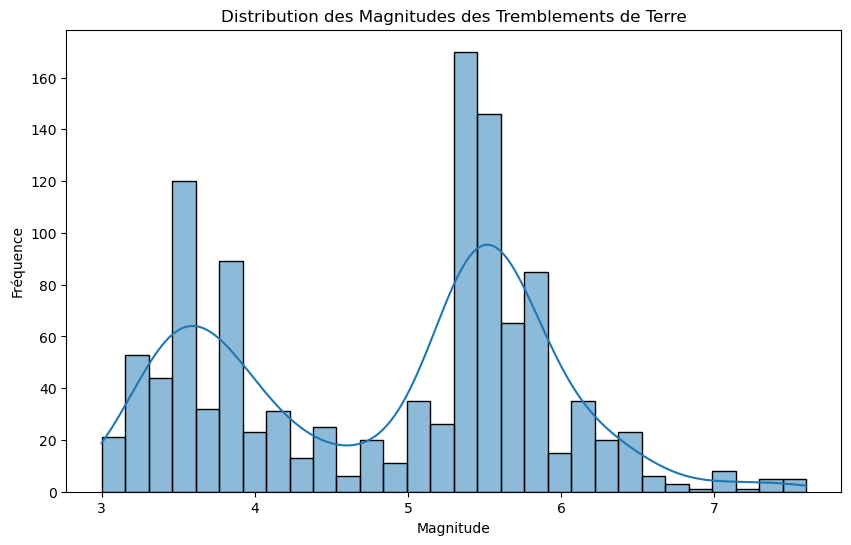

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['magnitude'], bins=30, kde=True)
plt.title('Distribution des Magnitudes des Tremblements de Terre')
plt.xlabel('Magnitude')
plt.ylabel('Fréquence')
plt.show()


In [28]:
high_magnitude_earthquakes = df[df['magnitude'] > 5.0]
#print(high_magnitude_earthquakes)


 ### 1. Chargement et Prétraitement des Données

In [56]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Charger les données (Assurez-vous de remplacer le chemin par celui de votre fichier)
# df = pd.read_csv('path/to/your/data.csv')

# Afficher les premières lignes
#print(df.head())

# Assignation de toutes les variables à X, sauf la variable cible 'magnitude'
X = df[['type', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 
         'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'net', 
         'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap', 
         'magType', 'geometryType', 'depth', 'latitude', 'longitude', 
         'place', 'distanceKM', 'placeOnly', 'location', 'continent', 
         'country', 'subnational', 'city', 'locality', 'postcode', 
         'what3words', 'timezone', 'locationDetails']]

# Supposons que 'magnitude' soit notre variable cible
y = df['magnitude']

# Gestion des valeurs manquantes (par exemple, en supprimant les lignes avec des valeurs manquantes)
X = X.dropna()
y = y[X.index]  # Assurez-vous que y correspond à X

# Normalisation des données (s'assurer que les colonnes sont numériques)
# Convertir les colonnes non numériques en valeurs numériques si nécessaire
X_numeric = pd.get_dummies(X, drop_first=True)  # Utiliser le codage one-hot pour les variables catégorielles

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Afficher les formes des ensembles
print("Ensemble d'entraînement : ", X_train.shape, y_train.shape)
print("Ensemble de test : ", X_test.shape, y_test.shape)

Ensemble d'entraînement :  (54, 455) (54,)
Ensemble de test :  (14, 455) (14,)


In [60]:
X

,type,title,date,time,updated,url,detailUrl,felt,cdi,mmi,alert,status,tsunami,sig,net,code,ids,sources,types,nst,dmin,rms,gap,magType,geometryType,depth,latitude,longitude,place,distanceKM,placeOnly,location,continent,country,subnational,city,locality,postcode,what3words,timezone,locationDetails
0,earthquake,"M 4.8 - 33 km WSW of Ackerly, Texas",2024-09-17T00:49:42,1726534182289,1726583895255,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,1893,6,5,green,reviewed,0,994,us,7000necw,",us7000necw,tx2024shcj,",",us,tx,",",dyfi,ground-failure,losspager,moment-tensor,o...",37,0.287000,0.48,70.0,mww,Point,4.0440,32.3984,-102.0440,"33 km WSW of Ackerly, Texas",33,"WSW of Ackerly, Texas","Ackerly, Texas",North America,United States of America (the),Texas,Tarzan-Lenorah,Tarzan-Lenorah,79783.0,landmass.perkily.affords,-300,"[{'id': '80684', 'wikidataId': '', 'name': '79..."
1,earthquake,"M 5.1 - 34 km WSW of Ackerly, Texas",2024-09-17T00:49:42,1726534182183,1726672002991,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,2042,6,5,green,reviewed,0,1040,tx,2024shcj,",us7000necw,tx2024shcj,",",us,tx,",",dyfi,ground-failure,losspager,moment-tensor,o...",24,0.000000,0.10,38.0,ml,Point,6.1279,32.4140,-102.0570,"34 km WSW of Ackerly, Texas",34,"WSW of Ackerly, Texas","Ackerly, Texas",North America,United States of America (the),Texas,Tarzan-Lenorah,Tarzan-Lenorah,79331.0,escalator.grownups.dwell,-300,"[{'id': '89341', 'wikidataId': '', 'name': '48..."
8,earthquake,"M 4.7 - 6 km N of Malibu, CA",2024-09-12T14:28:21,1726151301610,1726670314039,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,18592,5,5,green,reviewed,1,818,ci,40731623,",ew1726151300,ci40731623,at00sjpev8,us7000nda7,",",ew,ci,at,us,",",dyfi,focal-mechanism,impact-link,losspager,mo...",145,0.032380,0.29,101.0,mw,Point,11.3500,34.0703,-118.8080,"6 km N of Malibu, CA",6,"N of Malibu, CA","Malibu, CA",North America,United States of America (the),California,Los Angeles,Agoura Hills-Malibu,90265.0,quaint.pebbly.incline,-420,"[{'id': '93478', 'wikidataId': 'Q844837', 'nam..."
18,earthquake,"M 4.3 - 1 km ESE of The Geysers, CA",2024-09-07T14:30:36,1725719436710,1725896567027,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,241,5,5,green,reviewed,1,398,nc,75058606,",ew1725719440,nc75058606,at00sjg5n2,us6000nqax,",",ew,nc,at,us,",",dyfi,focal-mechanism,impact-link,losspager,mo...",121,0.009855,0.10,17.0,mw,Point,0.1600,38.7765,-122.7460,"1 km ESE of The Geysers, CA",1,"ESE of The Geysers, CA","The Geysers, CA",North America,United States of America (the),California,Cloverdale-Geyserville,Cloverdale-Geyserville,95441.0,riper.persuasive.earthly,-420,"[{'id': '89062', 'wikidataId': '', 'name': '06..."
51,earthquake,"M 4.4 - 4 km SSE of Highland Park, CA",2024-08-12T19:20:24,1723490424670,1726515029672,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,24227,5,5,green,reviewed,1,836,ci,40699207,",ew1723490420,ci40699207,at00si4dq0,us6000njp1,",",ew,ci,at,us,",",dyfi,focal-mechanism,impact-link,losspager,mo...",192,0.032990,0.24,24.0,mw,Point,10.9800,34.0843,-118.1850,"4 km SSE of Highland Park, CA",4,"SSE of Highland Park, CA","Highland Park, CA",North America,United States of America (the),California,Los Angeles,Los Angeles,90032.0,mass.bind.fields,-420,"[{'id': '93478', 'wikidataId': 'Q844837', 'nam..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,earthquake,"M 4.5 - 5 km ENE of Edmond, Oklahoma",2024-01-13T11:36:21,1705145781859,1705147019137,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,205,5,6,green,reviewed,0,410,us,6000m3hx,",us6000m3hx,",",us,",",dyfi,losspager,

In [72]:
# Affichage du tableau sous forme de joli tableau
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir X_scaled en DataFrame pour l'affichage
# Utilisez les colonnes d'origine de X, pas de X_scaled
X_df = pd.DataFrame(X_scaled, columns=pd.get_dummies(X, drop_first=True).columns)

# Afficher le tableau avec Seaborn
#plt.figure(figsize=(12, 8))
#sns.set_theme(style="whitegrid")

# Calculer la matrice de corrélation
#corr = X_df.corr()

# Afficher la matrice de corrélation avec une carte thermique
#sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
#plt.title("Matrice de Corrélation des Variables")
#plt.show()


###  2 .Application des modeles AGB ET GBR aux Données mondiales sur les tremblements de terre

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

# Modèle GBR
gbr_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=2)
gbr_model.fit(X_train, y_train)

# Prédictions pour le GBR
y_gbr_pred = gbr_model.predict(X_test)


# Modèle AGB
agb_model = AcceleratedGradientBoosting(n_estimators=150, learning_rate=0.1, max_depth=2)
agb_model.fit(X_train, y_train)

# Prédictions pour l'AGB
y_agb_pred = agb_model.predict(X_test)

# 3. Évaluation des Modèles

In [74]:
from sklearn.metrics import mean_squared_error, r2_score

# Évaluer les performances des modèles
mse_gbr = mean_squared_error(y_test, y_gbr_pred)
r2_gbr = r2_score(y_test, y_gbr_pred)

mse_agb = mean_squared_error(y_test, y_agb_pred)
r2_agb = r2_score(y_test, y_agb_pred)

print(f'MSE GBR: {mse_gbr}, R² GBR: {r2_gbr}')
print(f'MSE AGB: {mse_agb}, R² AGB: {r2_agb}')


MSE GBR: 0.0700941571351588, R² GBR: 0.6543680614637138
MSE AGB: 0.0771409854198429, R² AGB: 0.6196203874761197


# 4. Visualisation des Résultats

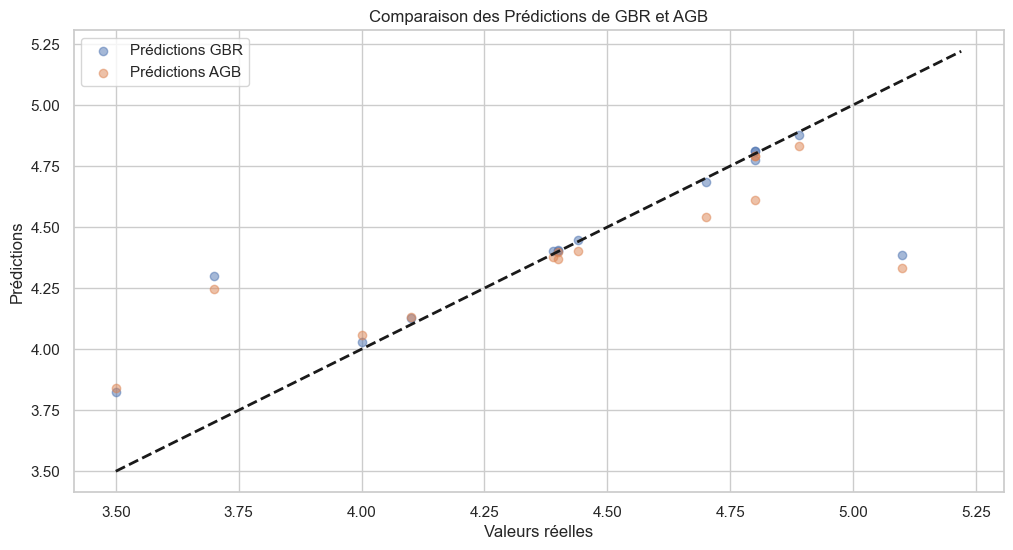

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_gbr_pred, label='Prédictions GBR', alpha=0.5)
plt.scatter(y_test, y_agb_pred, label='Prédictions AGB', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # ligne de référence
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des Prédictions de GBR et AGB')
plt.legend()
plt.show()
